# Small World Graphs

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 3

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import networkx as nx
import numpy as np

import thinkplot

# colors from our friends at http://colorbrewer2.org
COLORS = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462',
          '#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffed6f']

In [2]:
from thinkstats2 import RandomSeed
RandomSeed(17)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [3]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [4]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [5]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [6]:
lattice = make_ring_lattice(10, 4)

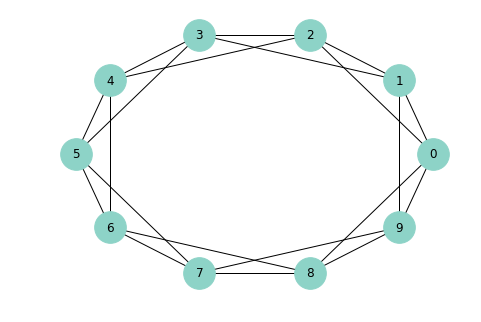

In [7]:
nx.draw_circular(lattice, 
                 node_color=COLORS[0], 
                 node_size=1000, 
                 with_labels=True)
plt.savefig('chap03-1.pdf')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=2` or `k=5`.

## WS graph

To make a WS, you start with a ring lattice and then rewire.

In [8]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [9]:
from numpy.random import choice

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G.nodes())
    for edge in G.edges():
        if flip(p):
            u, v = edge
            choices = nodes - {u} - set(G[u])
            new_v = choice(tuple(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

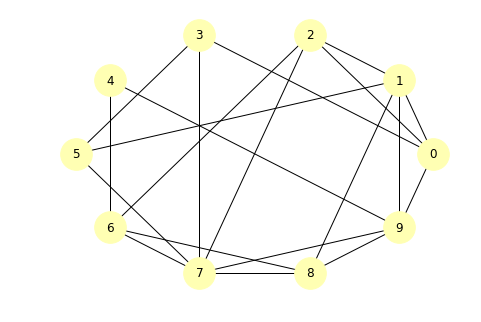

In [10]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color=COLORS[1], 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [11]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

/home/gsteelman/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/gsteelman/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/gsteelman/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/gsteelman/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(

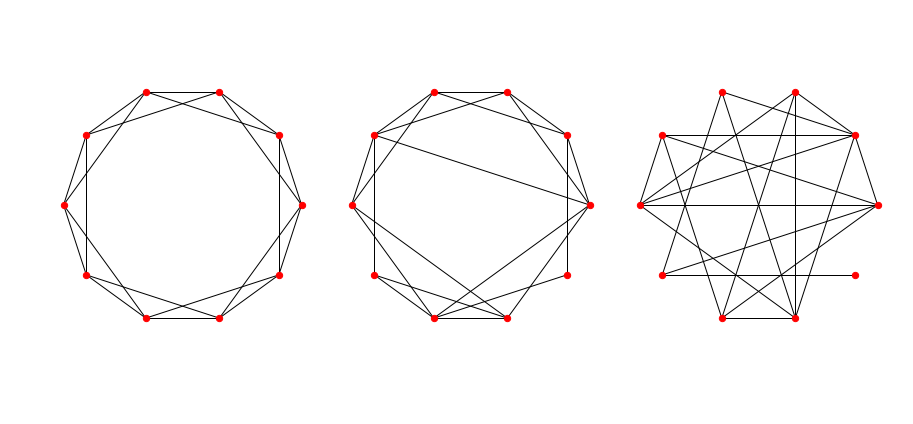

In [12]:
n = 10
k = 4
ns = 40

thinkplot.preplot(cols=3)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

thinkplot.subplot(3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
thinkplot.config(axis='equal')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
plt.savefig('chap03-2.pdf')

**Exercise:** What is the order of growth of `rewire`?

In [13]:
#N(N * K)

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [35]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / total

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [43]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cc = np.mean([new_node_clustering(G, node) for node in G])
    return cc

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [37]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [38]:
clustering_coefficient(lattice)

0.5

Correct.

**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.

In [45]:
def new_node_clustering(G, u):
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return 0
        
    total = k * (k-1) / 2
    exist = 0    
    exist = sum([1 for v, w in all_pairs(neighbors) if G.has_edge(v, w)])
    return exist / total

0.5

**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [19]:
# O(m) (if m means number of edges)

## Path length

The following function computes path lengths between all pairs of nodes

In [46]:
def path_lengths(G):
    length_map = nx.shortest_path_length(G)
    lengths = [length_map[u][v] for u, v in all_pairs(G)]
    return lengths

The characteristic path length is the mean path length for all pairs.

In [47]:
def characteristic_path_length(G):
    return np.mean(path_lengths(G))

On a complete graph, the average path length should be 1

In [48]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

1.0

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [49]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [50]:
lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.6666666666666667

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [51]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes about a second on my computer:

In [52]:
%time run_one_graph(1000, 10, 0.01)

8.34098298298 0.645819119769
CPU times: user 1.12 s, sys: 12 ms, total: 1.13 s
Wall time: 1.13 s


(8.3409829829829825, 0.64581911976911976)

Now we'll run it with a range of values for `p`.

In [53]:
ps = np.logspace(-4, 0, 9)
print(ps)

[  1.00000000e-04   3.16227766e-04   1.00000000e-03   3.16227766e-03
   1.00000000e-02   3.16227766e-02   1.00000000e-01   3.16227766e-01
   1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [54]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: sequence of (mpl, cc) pairs
    """
    res = {}
    for p in ps:
        print(p)
        res[p] = []
        for _ in range(iters):
            res[p].append(run_one_graph(n, k, p))
    return res

Here are the raw results

In [55]:
res = run_experiment(ps)

0.0001
39.9346046046 0.666206565657
50.4504504505 0.666666666667
50.4504504505 0.666666666667
43.4488648649 0.666206565657
50.4504504505 0.666666666667
48.7682702703 0.666423232323
50.4504504505 0.666666666667
48.3632872873 0.666134343434
40.7605185185 0.666278787879
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
50.4504504505 0.666666666667
38.2867227227 0.665890909091
37.4368528529 0.665674242424
49.0361341341 0.666278787879
50.4504504505 0.666666666667
40.4401361361 0.666423232323
50.4504504505 0.666666666667
50.4504504505 0.666666666667
0.000316227766017
38.4603363363 0.666351010101
34.0712672673 0.66571969697
35.8155315315 0.665674242424
27.3732312312 0.665503030303
36.3414234234 0.665890909091
35.5566306306 0.666035353535
42.8013373373 0.666423232323
45.3793073073 0.665602020202
34.1404844845 0.665890909091
38.4675195195 0.666351010101
33.7613693694 0.665220707071
33.3603183183 0.666035353535
38.586990991 0.666423232323
44.3120540541 0.6664

Now we have to extract them in a form we can plot

In [30]:
L = []
C = []
for p, t in sorted(res.items()):
    mpls, ccs = zip(*t)
    mpl = np.mean(mpls)
    cc = np.mean(ccs)
    L.append(mpl)
    C.append(cc)
    
print(L)
print(C)

[47.153509909909921, 38.388214414414421, 27.601071771771775, 16.023970970970971, 8.8731543543543534, 5.9947393393393389, 4.436626826826827, 3.5785572572572568, 3.2671586586586585]
[0.66648752525252497, 0.66589131313131311, 0.6647615909090907, 0.66104016594516579, 0.64724840548340556, 0.60793369602619596, 0.49004759712509716, 0.21974964924781104, 0.0093260291789393941]


And normalize them so they both start at 1.0

In [31]:
L = np.array(L) / L[0]
C = np.array(C) / C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

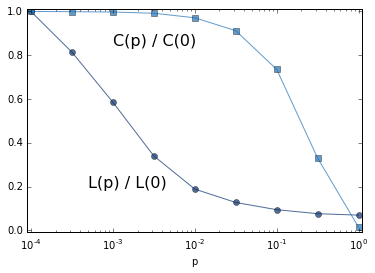

In [32]:
thinkplot.plot(ps, L, style='o-', linewidth=1)
thinkplot.plot(ps, C, style='s-', linewidth=1)
thinkplot.text(0.001, 0.9, 'C(p) / C(0)')
thinkplot.text(0.0005, 0.25, 'L(p) / L(0)')
thinkplot.config(xlabel='p', xscale='log',
                 xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])
plt.savefig('chap03-3.pdf')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [33]:
lattice = make_ring_lattice(10, 4)

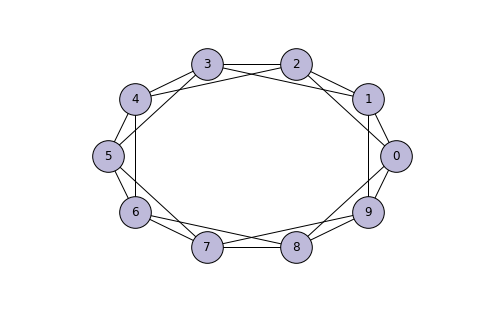

In [34]:
nx.draw_circular(lattice, 
                 node_color=COLORS[2], 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [18]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [36]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [37]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) 
            neighbors -= seen
            queue.extend(neighbors)
    return seen

It works, too.

In [38]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [14]:
def shortest_path_dijkstra(G, start):
    """Finds shortest paths from `start` to all other nodes.
    
    G: graph
    start: node to start at
    
    returns: make from node to path length
    """
    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [15]:
lattice = make_ring_lattice(10, 4)

/home/gsteelman/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/gsteelman/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/gsteelman/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/gsteelman/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(

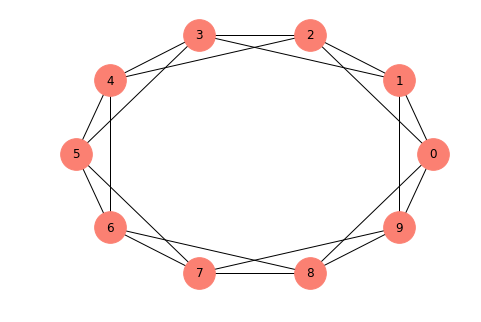

In [16]:
nx.draw_circular(lattice, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [19]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

And here's the result from NetworkX:

In [20]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 1, 9: 1}

They are the same:

In [21]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [26]:
#Should be n/k or 1000/10 or 100
lattice = make_ring_lattice(1000, 10)
d1 = shortest_path_dijkstra(lattice, 0)
max(d1.values())


100

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [71]:
def make_regular_graph(n,k):
    if (n*k)%2 == 1 or n <= k :
        raise ValueError
    G = nx.Graph()
    filled = set()
    nodes = set(range(n))
    G.add_nodes_from(nodes)
    for node in nodes:
        while node not in filled:
            if len(G[node]) >= k:
                filled.add(node)
                break
            choices = nodes - {node} - set(G[node]) - filled
#             print(choices)
            if not choices: #I think it sometimes works itself into a corner so I call the function again...I kno its cheap
                return make_regular_graph(n,k)
            new_v = choice(tuple(choices))
            
            G.add_edge(node, new_v)
            if len(G[new_v]) >= k:
                filled.add(new_v)
            
    return G

    

/home/gsteelman/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/gsteelman/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/gsteelman/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/gsteelman/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn(

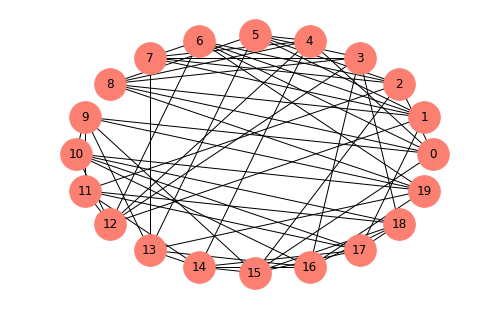

In [80]:
g = make_regular_graph(20,6)
nx.draw_circular(g, 
                 node_color=COLORS[3], 
                 node_size=1000, 
                 with_labels=True)

In [73]:
# Solution goes here

In [74]:
# Solution goes here

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [82]:
def plain_bfs(G, source):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [99]:
import time
g = make_regular_graph(20,6)

start = time.time()
for i in range(100000):
    plain_bfs(g,0)
end = time.time()
print(end - start)

1.8624396324157715


In [100]:
import time
g = make_regular_graph(20,6)

start = time.time()
for i in range(100000):
    reachable_nodes_bfs(g,0)
end = time.time()
print(end - start)

2.9130897521972656


In [109]:
def bfs_dijkstra(G, source):
    """A fast BFS node generator"""
    seen = {}
    nextlevel = {source}
    dist = 0
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen[v] =dist
                nextlevel.update(G[v])
        dist +=1
    return seen



In [110]:
lattice = make_ring_lattice(100, 5)
d1 = bfs_dijkstra(lattice, 0)
d1

{0: 0,
 1: 1,
 2: 1,
 3: 2,
 4: 2,
 5: 3,
 6: 3,
 7: 4,
 8: 4,
 9: 5,
 10: 5,
 11: 6,
 12: 6,
 13: 7,
 14: 7,
 15: 8,
 16: 8,
 17: 9,
 18: 9,
 19: 10,
 20: 10,
 21: 11,
 22: 11,
 23: 12,
 24: 12,
 25: 13,
 26: 13,
 27: 14,
 28: 14,
 29: 15,
 30: 15,
 31: 16,
 32: 16,
 33: 17,
 34: 17,
 35: 18,
 36: 18,
 37: 19,
 38: 19,
 39: 20,
 40: 20,
 41: 21,
 42: 21,
 43: 22,
 44: 22,
 45: 23,
 46: 23,
 47: 24,
 48: 24,
 49: 25,
 50: 25,
 51: 25,
 52: 24,
 53: 24,
 54: 23,
 55: 23,
 56: 22,
 57: 22,
 58: 21,
 59: 21,
 60: 20,
 61: 20,
 62: 19,
 63: 19,
 64: 18,
 65: 18,
 66: 17,
 67: 17,
 68: 16,
 69: 16,
 70: 15,
 71: 15,
 72: 14,
 73: 14,
 74: 13,
 75: 13,
 76: 12,
 77: 12,
 78: 11,
 79: 11,
 80: 10,
 81: 10,
 82: 9,
 83: 9,
 84: 8,
 85: 8,
 86: 7,
 87: 7,
 88: 6,
 89: 6,
 90: 5,
 91: 5,
 92: 4,
 93: 4,
 94: 3,
 95: 3,
 96: 2,
 97: 2,
 98: 1,
 99: 1}

In [111]:
import time
g = make_regular_graph(20,6)

start = time.time()
for i in range(100000):
    shortest_path_dijkstra(g,0)
end = time.time()
print(end - start)

3.546884775161743


In [113]:
import time
g = make_regular_graph(20,6)

start = time.time()
for i in range(100000):
    bfs_dijkstra(g, 0)
end = time.time()
print(end - start)
#Hey mines actually faster

2.017123222351074


In [57]:
# Solution goes here

In [58]:
# Solution goes here

In [59]:
# Solution goes here

**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [60]:
def bfs(top_node, visit):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [top_node]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visit(curr_node)            # Visit the node
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in curr_node.children
                     if c not in visited and c not in queue)

In [61]:
#You are searching queue for a value in queque each time, since it is a list, this will be take the length of queque.
#to search, also popping left from the queue will also take the same amount of time
# So it adds bothe the average length of queque and number of connections times length of queue.

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [62]:
def shortest_path_dijkstra_dfs(G, start):

    dist = {start: 0}
    queue = deque([start])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1
        neighbors = set(G[node]) - set(dist)
        for n in neighbors:
            shortest_path_dijkstra_dfs(G,n)
        queue.extend(neighbors)
    return dist

In [ ]:
#I don't really know how I would implement this without it erroring. To use DPS you have to do it recursively
#meaning there would have to be a list or a dictionary passed in saying what was visited, but it would be 
#difficult to know where you are in the graph and when to update a value in the dicitonary when calling
#the function recursively, if it is possible at all.